https://www.kaggle.com/kenconstable/alzheimer-s-multi-class-classification#Alzheimers-Multiclass-Classification

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install tqdm

In [4]:
!pip install split-folders

In [5]:
!pip3 install scikit-image

**Keras Tuner**는 TensorFlow 프로그램에 대한 최적의 하이퍼파라미터 세트를 선택하는 데 도움을 주는 라이브러리입니다. 
머신러닝(ML) 애플리케이션에 대한 올바른 하이퍼파라미터 세트를 선택하는 과정을 하이퍼파라미터 조정 또는 하이퍼튜닝이라고 합니다.

하이퍼파라미터는 훈련 프로세스 및 ML 모델의 토폴로지를 제어하는 변수입니다. 
이러한 변수는 훈련 과정에서 일정하게 유지되며 ML 프로그램의 성능에 직접적으로 영향을 미칩니다. 
하이퍼파라미터에는 두 가지 유형이 있습니다.

> 1. 숨겨진 레이어의 수 및 너비와 같이 모델 선택에 영향을 미치는 모델 하이퍼파라미터
> 2. SGD(Stochastic Gradient Descent)의 학습률 및 KNN(k Nearest Neighbors) 분류자의 최근접 이웃 수와 같은 학습 알고리즘의 속도와 품질에 영향을 주는 알고리즘 하이퍼파라미터

이 튜토리얼에서는 Keras Tuner를 사용하여 이미지 분류 애플리케이션에 하이퍼튜닝을 수행합니다.

- 출처 : https://www.tensorflow.org/tutorials/keras/keras_tuner?hl=ko

In [6]:
!pip install keras-tuner

     |████████████████████████████████| 97 kB 5.0 MB/s 


In [7]:
# Import Libraries
import numpy as np 
import pandas as pd 
import time
import itertools

# file system libraries
import os
import os.path
from   os import path
import shutil

# confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# splits train folders into train/validation with stratification
import splitfolders  

# Images, Plotting
from skimage import io
import matplotlib.pyplot as plt
import tensorflow.keras.preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

# tensorflow - CNNs
import tensorflow as tf
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras import backend, models, layers, Sequential
from tensorflow.keras.layers import Input, Concatenate, Dense, Dropout, Flatten, Add
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.applications import DenseNet121,InceptionV3, Xception, ResNet101
from kerastuner.tuners import Hyperband

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.


# 경로 및 시드 지정

In [8]:
os.getcwd()

'/content'

In [9]:
ls

drive/  sample_data/


In [10]:
# 주피터 노트북버전 경로
# FOLDERS     = ['train','val','test']
# DIR_INPUT   = './Alzheimer_s Dataset'
# DIR_WORK    = './'
# DIR_MODELS  = os.path.join(DIR_WORK,'models')
# DIR_TRAIN   = os.path.join(DIR_WORK,'train')
# DIR_VAL     = os.path.join(DIR_WORK,'val')
# DIR_TEST    = os.path.join(DIR_WORK,'test')
# CLASS_LIST  = ['MildDememted','ModerateDemented','NonDememted','VeryMildDemented']


# # Set seeds for reproducibility 
# SEED        = 1985
# tf.random.set_seed(SEED)
# np.random.seed(SEED)

In [11]:
# 구글코랩 버전 경로

FOLDERS     = ['train','val','test']
DIR_INPUT   = '/content/drive/MyDrive/Colab_Notebooks/mentoring/brain/Alzheimer_sDataset'
DIR_WORK    = '/content/drive/MyDrive/Colab_Notebooks/mentoring/brain'
DIR_MODELS  = os.path.join(DIR_WORK,'models')
DIR_TRAIN   = os.path.join(DIR_WORK,'train')
DIR_VAL     = os.path.join(DIR_WORK,'val')
DIR_TEST    = os.path.join(DIR_WORK,'test')
CLASS_LIST  = ['MildDememted','ModerateDemented','NonDememted','VeryMildDemented']


# Set seeds for reproducibility 
SEED        = 1985
tf.random.set_seed(SEED)
np.random.seed(SEED)

# Train/Test set의 각 class별 이미지 개수

In [12]:
from glob import glob

In [13]:
glob(os.path.join(DIR_INPUT, '*'))

['/content/drive/MyDrive/Colab_Notebooks/mentoring/brain/Alzheimer_sDataset/train',
 '/content/drive/MyDrive/Colab_Notebooks/mentoring/brain/Alzheimer_sDataset/test']

In [14]:
for (a, b, c) in os.walk(os.path.join(DIR_INPUT, 'train')):
    print(a)  # os.walk(root주소) : root주소 출력
#     print(b)  # root주소 안에있는 폴더들 출력
#     print(c)  # b에서 출력된 폴더 하위의 파일들 출력
#     for file in c:
#         print(a)

/content/drive/MyDrive/Colab_Notebooks/mentoring/brain/Alzheimer_sDataset/train
/content/drive/MyDrive/Colab_Notebooks/mentoring/brain/Alzheimer_sDataset/train/VeryMildDemented
/content/drive/MyDrive/Colab_Notebooks/mentoring/brain/Alzheimer_sDataset/train/ModerateDemented
/content/drive/MyDrive/Colab_Notebooks/mentoring/brain/Alzheimer_sDataset/train/MildDemented
/content/drive/MyDrive/Colab_Notebooks/mentoring/brain/Alzheimer_sDataset/train/NonDemented


In [15]:
def images_by_class(path, folders):
    """
    Loop through the path/folders count the number and proportions of each class
    """

    # accumulators
    normal, verymild, mild, moderate = 0, 0, 0, 0

    # print header
    msg = '{:8} {:8} {:11} {:7} {:9} {:9} {:11} {:8} {:8}'.format('folder', 'normal', 'verymild', 'mild', 'moderate',
                                                                  'normal %', 'verymild %', 'mild %', 'moderate %')
    print(msg)
    print("-"*len(msg))

    # FOLDERS = ['train','val','test'] 
    for folder in FOLDERS:
        # dirname은 os.path.join(path, folder) 이므로 각 train/val/test의 폴더 주소
        # filesnames는 각 이미지
        # filesnames는 dirname에 귀속되어있으므로 각 filesnames의 dirname에 어떤 class가 존재하는지를 count
        for dirname, _, filenames in os.walk(os.path.join(path, folder)):
            for file in filenames:
                if "NonDemented" in dirname:
                    normal += 1
                if "VeryMildDemented" in dirname:
                    verymild += 1
                if 'MildDemented' in dirname:
                    mild += 1
                if 'ModerateDemented' in dirname:
                    moderate += 1

        # 각 클래스별 이미지비율 계산
        total = normal+verymild+mild+moderate
        if total > 0:
            n = round(normal/total, 2)*100
            vm = round(verymild/total, 2)*100
            m = round(mild/total, 2)*100
            mo = round(moderate/total, 2)*100
        else:
            n, vm, m, mo = 0, 0, 0, 0

        print("{:6} {:8} {:10} {:7} {:11} {:8} {:10} {:8} {:12}".format(
            folder, normal, verymild, mild, moderate, n, vm, m, mo))
        normal, verymild, mild, moderate = 0, 0, 0, 0

In [16]:
# Images by class in the input directory
images_by_class(DIR_INPUT,FOLDERS) 

folder   normal   verymild    mild    moderate  normal %  verymild %  mild %   moderate %
-----------------------------------------------------------------------------------------
train      2560       1792    2509          52     37.0       26.0     36.0          1.0
val           0          0       0           0        0          0        0            0
test        640        448     627          12     37.0       26.0     36.0          1.0


# 디렉토리 생성

In [21]:
# create a new directory if it doesn't exist
def create_dir(dir_path,folder,verbose=True):
    """
    dir_path/folder 경로가 존재하지 않으면 생성
    """
    msg = ""
    folder_path = os.path.join(dir_path,folder)
    
    if not path.exists(folder_path):
        try:
            os.mkdir(folder_path)
            msg = folder_path + ' created'
        except OSError as err:
            print('Error creating folder:{} with error:{}'.format(folder_path,err))
    if verbose:
        print(msg)
        
    return folder_path

In [22]:
# models 폴더 추가
create_dir(DIR_WORK,'models',True)

'/content/drive/MyDrive/Colab_Notebooks/mentoring/brain/models'

# Train/Validation Set 나누기

In [23]:
def resample_train_val_images(input_dir,working_dir,seed=SEED,split = (0.80,0.20)):
    """
    train의 이미지를 train/validation으로 나누고 사용할 폴더위치를 바꿈
    """
    # 기존의 train/test 폴더 존재하는 경로
    dir_test   = os.path.join(input_dir,'test')
    dir_train  = os.path.join(input_dir,'train')
    

    # FOLDERS = ['train','val','test']
    # 만약에 이미 폴더가 존재하면 삭제
    # shutil.rmtree('경로') : 지정된 폴더와 하위 디렉토리 폴더, 파일를 모두 삭제
    for folder in FOLDERS:
        if path.exists(os.path.join(working_dir,folder)):
            shutil.rmtree(os.path.join(working_dir,folder))

            
    # shutil.copytree("./test1", "./test2") : test1 폴더에 들어있는 파일과 폴더를 test2에 복사.
                                            # test2 폴더는 기존에 존재하지 않은 폴더로 copytree 함수가 실행될때 새로 만들어짐. 이미 있다면 에러
    # https://ponyozzang.tistory.com/439
    shutil.copytree(dir_test, os.path.join(working_dir,'test'))
    
     # train/validation set을 나눔
        # https://lynnshin.tistory.com/46
    splitfolders.ratio(dir_train, working_dir, seed=seed, ratio=split) 
        
    # 
    print("\n Images By Class After Resampling")
    print("-"*67)
    images_by_class(working_dir,FOLDERS)

In [24]:
resample_train_val_images(DIR_INPUT,DIR_WORK)

Copying files: 5121 files [40:55,  2.09 files/s]


 Images By Class After Resampling
-------------------------------------------------------------------
folder   normal   verymild    mild    moderate  normal %  verymild %  mild %   moderate %
-----------------------------------------------------------------------------------------
train      2048       1433    2006          41     37.0       26.0     36.0          1.0
val         512        359     503          11     37.0       26.0     36.0          1.0
test        640        448     627          12     37.0       26.0     36.0          1.0


# 이미지 전처리

In [25]:
# 이미지크기 / batch size 설정
IMG_SIZE = [176,208]
BATCH_SIZE = 32

In [26]:
# 이미지 각 픽셀들 정규화
train_images = ImageDataGenerator(rescale  = 1./255)
val_images   = ImageDataGenerator(rescale  = 1./255)
test_images  = ImageDataGenerator(rescale  = 1./255)

In [27]:
# 데이터셋 생성

# train images: 4098
train_gen =train_images.flow_from_directory(
    DIR_TRAIN,
    target_size = IMG_SIZE,
    batch_size  = BATCH_SIZE,
    class_mode  = 'categorical',
    color_mode  = 'rgb',          # convert to rgb
    seed        = SEED 
)

# validation images: 1023
val_gen = val_images.flow_from_directory(
    DIR_VAL,
    target_size = IMG_SIZE,
    batch_size  = BATCH_SIZE,
    class_mode  = 'categorical',
    color_mode  = 'rgb',         # convert to rgb
    seed        = SEED
)

# test images:1279
test_gen = test_images.flow_from_directory(
    DIR_TEST,
    target_size = IMG_SIZE,
    batch_size  = BATCH_SIZE,
    class_mode  = 'categorical',
    color_mode  = 'rgb',         # convert to rgb
    seed        = SEED,
    shuffle     = False
)

Found 4095 images belonging to 4 classes.
Found 1026 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


In [28]:
# train/val set의 각 epoch당 step 수
steps_per_epoch  = train_gen.n // train_gen.batch_size
print("steps per epoch:{}".format(steps_per_epoch))

steps per epoch:127


# 각 이미지를 라벨과 함께 시각화하여 확인

[0. 0. 0. 1.]
3


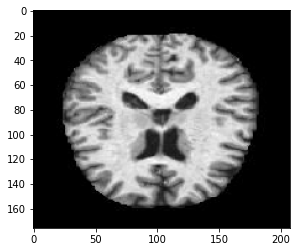

[0. 0. 0. 1.]
3


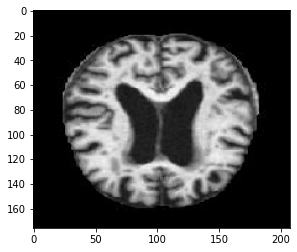

[0. 0. 1. 0.]
2


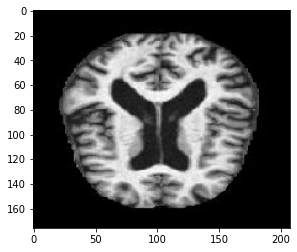

[0. 0. 0. 1.]
3


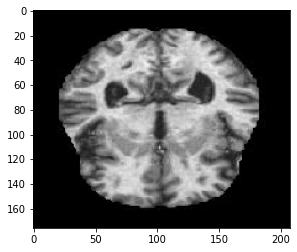

[0. 0. 0. 1.]
3


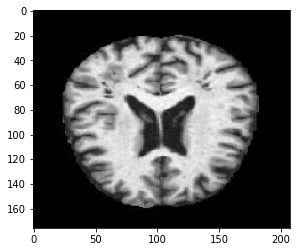

[0. 0. 1. 0.]
2


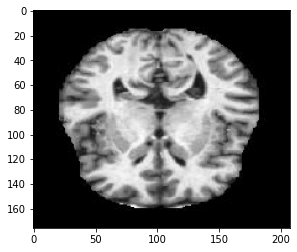

[0. 0. 1. 0.]
2


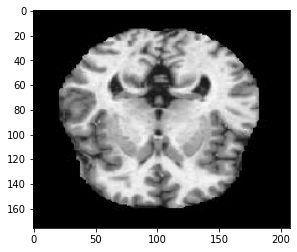

[0. 0. 1. 0.]
2


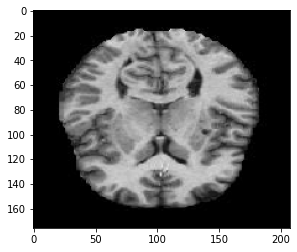

[0. 0. 1. 0.]
2


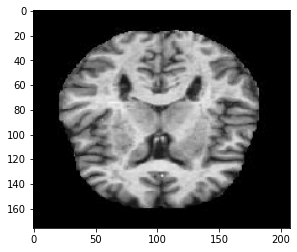

[0. 0. 1. 0.]
2


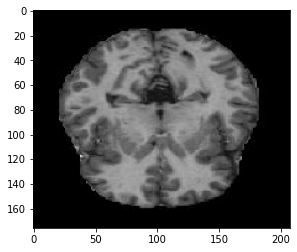

In [29]:
a, b = train_gen.next()
for i in range(10):
    print(b[i])
    print(np.argmax(b[i]))
    plt.imshow(a[i])
    plt.show()
    

In [30]:
def show_images(generator,y_pred=None):
    """
    Input: image generator(train_gen, val_gen, test_gen), y_pred=예상 라벨 (안 넣어도 됨)
    Output: 9개의 이미지를 라벨과 함께 보여줌
    """
    
    # get image lables
    labels =dict(zip([0,1,2,3], CLASS_LIST))
    
    # get a batch of images
    x,y = generator.next()
    
    # display a grid of 9 images
    plt.figure(figsize=(10, 10))
    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Class:{}".format(labels[np.argmax(y[i])]))
            
    else:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])],labels[y_pred[i]]))

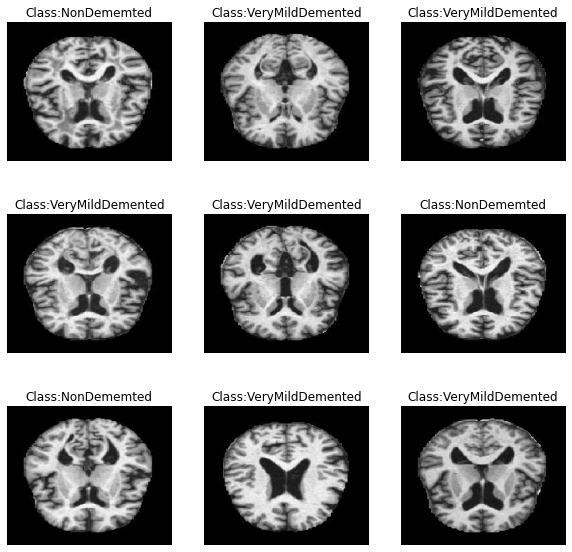

In [31]:
show_images(train_gen)

# 전이학습을 위한 모델의 기초뼈대 생성

In [32]:
def build_transfer_model(conv_base, dropout, conv_nodes, dense_node, learn_rate, metric):
    """
    전이학습을 위한 모델의 뼈대형성

    Input : 
        conv_base : 전이학습 모델
        dropout : dropout비율
        conv_nodes :  Conv2D layer의 노드 개수
        dense_node : 마지막 Dense layer의 node 개수
        learn_rate : 학습비율
        metric : 평가지표

    Output: 컴파일된 전이모델
    """

    # clear previous run
    backend.clear_session()

    # build the model
    model = Sequential()
    model.add(conv_base)
    model.add(Dropout(dropout))
    model.add(BatchNormalization())

    model.add(Conv2D(conv_nodes, 3, padding='same', activation='relu'))
    model.add(Conv2D(conv_nodes, 3, padding='same', activation='relu'))
    model.add(MaxPooling2D())
    model.add(Dropout(dropout + 0.10))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(dense_node,activation='relu'))
    model.add(Dense(4,activation='softmax'))


    # complile the model
    model.compile(
        optimizer = tensorflow.keras.optimizers.Adam(lr=learn_rate),
        loss      = 'categorical_crossentropy', 
        metrics   = metric )
    
    model.summary()
    return model

In [33]:
def freeze_layers(base,conv_num="conv5",block_num=1,max_block_num=16,trainable_layers='some'):
    """
    Input: A base transferable model,the layer name, the block number, the max number of blocks
           The layer name, block number and max of blocks only works with DenseNet121
    Output:Sets all layers to trainable from conv#_block_num to conv#_max_block_num
    
    """
    # https://www.tensorflow.org/guide/keras/transfer_learning?hl=ko
    # base.trainable = False : 모든 레이어의 가중치가 훈련 가능에서 훈련 불가능으로 이동
                            # 훈련 가능한 가중치가 훈련할 수 없게 되면 훈련 중에 그 값이 더는 업데이트되지 않는다.
    
    if trainable_layers=='none':
        base.trainable = False
        print("No Layers Trainable: Using Base Model Weights")
    if trainable_layers=='all':
        base.trainable =True
        print("All Layers Trainable: Base Model will be fully trained")
    
    if trainable_layers=='some':
        
        print("Some Layers of the Model will be Trainable:")
        print("---------------------------------------------")
        
        
         # 전이학습 모델의 가중치학습 동결
        base.trainable = False

        # conv#_block# 형태의 이름의 layer들은 학습가능한 가중치로 바꿈
        print('layer','\t\t\t','trainable')
        for block in range(block_num,max_block_num+1):
            for layer in conv_base.layers:
                if block>=block_num:
                    if conv_num +"_block"+str(block) in layer.name:
                        layer.trainable = True
                        print(layer.name,'\t',layer.trainable)

# Training Model 생성 및 학습

In [34]:
# 파라미터 값 지정
# EPOCHS        = 15
# early_stoping = EarlyStopping(monitor = 'val_auc',patience = 10,restore_best_weights=True)

# callbacks     = [early_stoping]
# metrics       = [tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.Accuracy(name='accuracy')]

In [35]:
# 학습에 필요한 파라미터
EPOCHS        = 150
early_stoping = EarlyStopping(monitor = 'val_auc',patience = 15,restore_best_weights=True)
reduce_lr     = ReduceLROnPlateau(monitor='val_auc',factor=0.9, patience=15, min_lr=1e-20, verbose=1, cooldown=3)
callbacks     = [reduce_lr]
metrics       = [tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.Accuracy(name='accuracy')]

In [36]:
conv_base = InceptionV3(weights = 'imagenet', include_top = False, input_shape = (*IMG_SIZE, 3))
for block in range(1, 16):
    for layer in conv_base.layers:
        if 'conv5' + '_block' + str(block) in layer.name:
            print(layer.name)

87924736/87910968 [==============================] - 1s 0us/step


In [37]:
# 모델 형성
# 전이학습할 모델(InceptionV3)
# Train Model: Base + Optimized Hyperparameters + Data Augmentation
conv_base = InceptionV3(weights = 'imagenet', include_top = False, input_shape = (*IMG_SIZE, 3))

# freeze layers for training
freeze_layers(conv_base,trainable_layers='none')

# build and compile the model
model = build_transfer_model(conv_base,dropout=0.5,conv_nodes=1024,dense_node =1024,learn_rate=0.001,metric=metrics)


# 학습
tic = time.perf_counter()
history = model.fit(
    train_gen,
    epochs           = EPOCHS,
    validation_data  = val_gen,
    verbose          = 2,
    callbacks        = callbacks  # early stopping 
)

# 모델 저장
model.save(os.path.join(DIR_MODELS,'model_added_layer'))

# 학습에 걸린 시간
toc = time.perf_counter()
print("Total Time:{} mins".format(round((toc-tic)/60,2)))

No Layers Trainable: Using Base Model Weights


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 4, 5, 2048)        21802784  
_________________________________________________________________
dropout (Dropout)            (None, 4, 5, 2048)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 4, 5, 2048)        8192      
_________________________________________________________________
conv2d (Conv2D)              (None, 4, 5, 1024)        18875392  
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 4, 5, 1024)        9438208   
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 2, 2, 1024)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2, 2, 1024)        0

## 모델 평가

In [40]:
def plot_training_metrics(train_hist,model,test_gen,y_actual,y_pred,classes):
    """
    Input
        train_hist : 학습한 모델 결과
        model : 학습한 모델
        test_gen : 테스트 데이터셋
        y_actual : 테스트 데이터셋의 실제 라벨
        y_pred : 모델이 예측한 테스트 데이터셋의 라벨
        classes : 라벨의 class 리스트
    
    Output: Plots loss vs epochs, accuracy vs epochs, confusion matrix
        평가지표 loss의 epoch별 train/val 그래프
        평가지표 auc의 epoch별 train/val 그래프
        confusion matrix
    """
    
    # 테스트 셋을 이용해서 모델평가
    test_loss, test_metric_auc, test_metric_acc = model.evaluate(test_gen,verbose = False)
    results_auc       = round(test_metric_auc, 2)*100 
    results_acc       = round(test_metric_acc, 2)*100
    results_title_auc ="\n Model AUC on Test Data:{}%".format(results_auc)
    results_title_acc ="\n Model ACCURACY on Test Data:{}%".format(results_acc)
    print(results_title_auc.format(results_auc))
    print(results_title_acc.format(results_acc))
    print(len(results_title_acc) * "-")
    
    # print classification report
    print(classification_report(y_actual, y_pred, target_names=classes))
    
     # extract data from training history for plotting
    history_dict    = train_hist.history
    loss_values     = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    auc_values      = history_dict['auc']
    val_auc_values  = history_dict['val_auc']
    acc_values      = history_dict['accuracy']
    val_acc_values  = history_dict['val_accuracy']
    epochs          = range(1, len(history_dict['auc']) + 1)

    # get the min loss and max accuracy for plotting
    max_auc = np.max(val_auc_values)
    min_loss = np.min(val_loss_values)
    
    # create plots
    plt.subplots(figsize=(16,4))
    
    # plot loss by epochs
    plt.subplot(1,4,1)
    plt.plot(epochs, loss_values, 'bo', label = 'Training loss')
    plt.plot(epochs, val_loss_values, 'cornflowerblue', label = 'Validation loss')
    plt.title('Validation Loss by Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.axhline(y=min_loss,color='darkslategray', linestyle='--')
    plt.legend()

    # plot AUC by epochs
    plt.subplot(1,4,2)
    plt.plot(epochs, auc_values, 'bo',label = 'Training AUC')
    plt.plot(epochs, val_auc_values, 'cornflowerblue', label = 'Validation AUC')
    plt.plot(epochs,[results_auc/100]*len(epochs),'darkmagenta',linestyle = '--',label='Test AUC')
    plt.title('Validation AUC by Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.axhline(y=max_auc,color='darkslategray', linestyle='--')
    plt.legend()

    
    # plot accuracy by epochs
    plt.subplot(1,4,3)
    plt.plot(epochs, acc_values, 'bo',label = 'Training ACCURACY')
    plt.plot(epochs, val_acc_values, 'cornflowerblue', label = 'Validation ACCURACY')
    plt.plot(epochs,[results_acc/100]*len(epochs),'darkmagenta',linestyle = '--',label='Test ACCURACY')
    plt.title('Validation ACCURACY by Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('ACCURACY')
    plt.axhline(y=max_auc,color='darkslategray', linestyle='--')
    plt.legend()
    
    
    # calculate Confusion Matrix
    cm = confusion_matrix(y_actual, y_pred)

    # create confusion matrix plot
    plt.subplot(1,4,4)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.BuPu)
    plt.title("Confusion Matrix \n AUC:{}%".format(results_auc))
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # loop through matrix, plot each 
    threshold = cm.max() / 2.
    for r, c in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(c, r, format(cm[r, c], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[r, c] > threshold else "black")
        
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()
    


 Model AUC on Test Data:83.0%

 Model ACCURACY on Test Data:5.0%
----------------------------------
              precision    recall  f1-score   support

        mild       0.61      0.44      0.51       179
    moderate       1.00      0.17      0.29        12
      normal       0.77      0.66      0.71       640
   very-mild       0.54      0.72      0.62       448

    accuracy                           0.65      1279
   macro avg       0.73      0.50      0.53      1279
weighted avg       0.67      0.65      0.65      1279



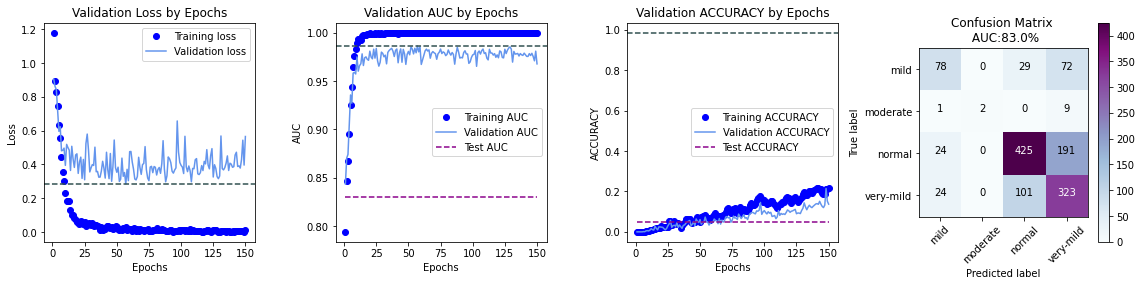

In [41]:
# get class predictions
y_prob = model.predict(test_gen)
y_pred = y_prob.argmax(axis=-1)

# get actual classes
y_actual = test_gen.classes

# plot
plot_training_metrics(history,model,test_gen,y_actual,y_pred,['mild','moderate','normal','very-mild'])

# Train Data Set Augmentation 했을때의 모델 학습

Found 4095 images belonging to 4 classes.


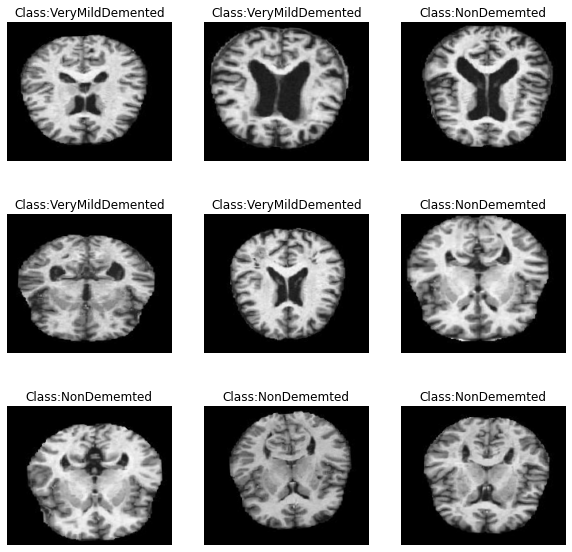

In [45]:
# Data Augmentation on training images
train_images_au = ImageDataGenerator(rescale            = 1./255,
                                  rotation_range     = 5,
                                  zoom_range         = 0.10,
                                  width_shift_range  =0.05,
                                  height_shift_range =0.05)

# train image generator
train_gen_au =train_images_au.flow_from_directory(
    DIR_TRAIN,
    target_size = IMG_SIZE,
    batch_size  = BATCH_SIZE,
    class_mode  = 'categorical',
    color_mode  = 'rgb',          
    seed        = SEED 
)

show_images(train_gen_au)

In [46]:
# 모델 형성
# 전이학습할 모델(InceptionV3)
# Train Model: Base + Optimized Hyperparameters + Data Augmentation
conv_base = InceptionV3(weights = 'imagenet', include_top = False, input_shape = (*IMG_SIZE, 3))

# freeze layers for training
freeze_layers(conv_base,trainable_layers='none')

# build and compile the model
model_au = build_transfer_model(conv_base,dropout=0.5,conv_nodes=1024,dense_node =1024,learn_rate=0.001,metric=metrics)


# 학습
tic = time.perf_counter()
history_au = model_au.fit(
    train_gen_au,
    epochs           = EPOCHS,
    validation_data  = val_gen,
    verbose          = 2,
    callbacks        = callbacks  # early stopping 
)

# 모델 저장
model_au.save(os.path.join(DIR_MODELS,'model_added_augmentation'))

# 학습에 걸린 시간
toc = time.perf_counter()
print("Total Time:{} mins".format(round((toc-tic)/60,2)))

No Layers Trainable: Using Base Model Weights


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 4, 5, 2048)        21802784  
_________________________________________________________________
dropout (Dropout)            (None, 4, 5, 2048)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 4, 5, 2048)        8192      
_________________________________________________________________
conv2d (Conv2D)              (None, 4, 5, 1024)        18875392  
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 4, 5, 1024)        9438208   
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 2, 2, 1024)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2, 2, 1024)        0


 Model AUC on Test Data:87.0%

 Model ACCURACY on Test Data:4.0%
----------------------------------
              precision    recall  f1-score   support

        mild       0.61      0.45      0.52       179
    moderate       1.00      0.17      0.29        12
      normal       0.72      0.84      0.77       640
   very-mild       0.65      0.58      0.62       448

    accuracy                           0.69      1279
   macro avg       0.75      0.51      0.55      1279
weighted avg       0.68      0.69      0.68      1279



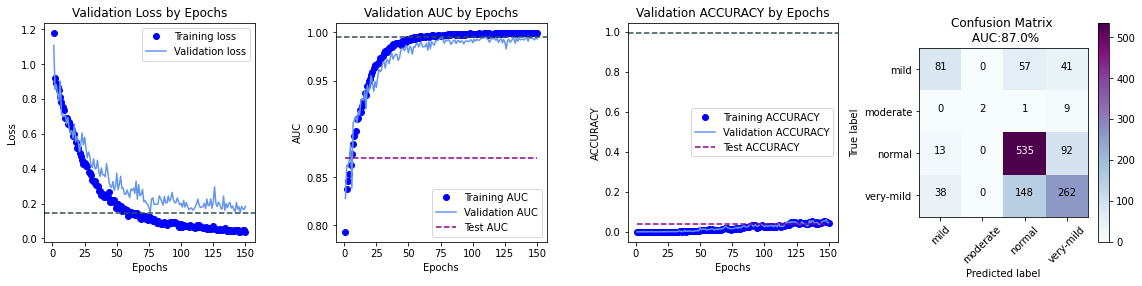

In [47]:
# get class predictions
y_prob = model_au.predict(test_gen)
y_pred = y_prob.argmax(axis=-1)

# get actual classes
y_actual = test_gen.classes

# plot
plot_training_metrics(history_au,model_au,test_gen,y_actual,y_pred,['mild','moderate','normal','very-mild'])

# 평가지표 및 콜백 수정

In [ ]:
def build_transfer_model(conv_base, dropout, conv_nodes, dense_node, learn_rate, metric):
    """
    전이학습을 위한 모델의 뼈대형성

    Input : 
        conv_base : 전이학습 모델
        dropout : dropout비율
        conv_nodes :  Conv2D layer의 노드 개수
        dense_node : 마지막 Dense layer의 node 개수
        learn_rate : 학습비율
        metric : 평가지표

    Output: 컴파일된 전이모델
    """

    # clear previous run
    backend.clear_session()

    # build the model
    model = Sequential()
    model.add(conv_base)
    model.add(Dropout(dropout))
    model.add(BatchNormalization())

    model.add(Conv2D(conv_nodes, 3, padding='same', activation='relu'))
    model.add(Conv2D(conv_nodes, 3, padding='same', activation='relu'))
    model.add(MaxPooling2D())
    model.add(Dropout(dropout + 0.10))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(dense_node,activation='relu'))
    model.add(Dense(4,activation='softmax'))


    # complile the model
    model.compile(
        optimizer = tensorflow.keras.optimizers.Adam(lr=learn_rate),
        loss      = 'categorical_crossentropy', 
        metrics   = metric )
    
    model.summary()
    return model

In [ ]:
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_acc') > 0.99:
            print("\nReached accuracy threshold! Terminating training.")
            self.model.stop_training = True
            
my_callback = MyCallback()

In [ ]:
# 학습에 필요한 파라미터
EPOCHS        = 100
early_stoping = EarlyStopping(monitor = 'val_auc',patience = 15,restore_best_weights=True)
reduce_lr     = ReduceLROnPlateau(monitor='val_auc',factor=0.9, patience=15, min_lr=1e-20, verbose=1, cooldown=3)
callbacks     = [reduce_lr, my_callback]
metrics       = [tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.CategoricalAccuracy(name='accuracy')]

In [47]:
# 모델 형성
# 전이학습할 모델(InceptionV3)
# Train Model: Base + Optimized Hyperparameters + Data Augmentation
conv_base = InceptionV3(weights = 'imagenet', include_top = False, input_shape = (*IMG_SIZE, 3))

# freeze layers for training
freeze_layers(conv_base,trainable_layers='none')

# build and compile the model
model_au = build_transfer_model(conv_base,dropout=0.5,conv_nodes=1024,dense_node =1024,learn_rate=0.001,metric=metrics)


# 학습
tic = time.perf_counter()
history_au = model_au.fit(
    train_gen_au,
    epochs           = EPOCHS,
    validation_data  = val_gen,
    verbose          = 2,
    callbacks        = callbacks  # early stopping 
)

# 모델 저장
model_au.save(os.path.join(DIR_MODELS,'model_added_callback'))

# 학습에 걸린 시간
toc = time.perf_counter()
print("Total Time:{} mins".format(round((toc-tic)/60,2)))

In [47]:
# get class predictions
y_prob = model_au.predict(test_gen)
y_pred = y_prob.argmax(axis=-1)

# get actual classes
y_actual = test_gen.classes

# plot
plot_training_metrics(history_au,model_au,test_gen,y_actual,y_pred,['mild','moderate','normal','very-mild'])
